## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense , GRU , SimpleRNN

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Appliances Energy Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/appliances+energy+prediction.zip'
extract_path = '/content/drive/MyDrive/extracted_folder'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

csv_path = '/content/drive/MyDrive/extracted_folder/energydata_complete.csv'
df = pd.read_csv(csv_path)

date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')

Mounted at /content/drive


In [ ]:
# Unwanted attributes , these are random variable they don't have any physical significance and interpretations
# They are present in dataset for eg: representing unknown or unmeasured factors, introducing noise or variability,
df.pop('rv1')
df.pop('rv2')

In [ ]:
df = df.dropna() # any missing values (if any) will be dropped
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [ ]:
features = ['Appliances','lights','T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4','T5','RH_5','T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9','T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint']
num_features = len(features)
len(features)

26

## Splitting of Data in 70:20:10 for ( training , validation , testing ) sets

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*(70/100))]
val_df = df[int(n*(70/100)):int(n*(90/100))]
test_df = df[int(n*(90/100)):]

num_features = df.shape[1]
print(num_features)

26


## Normalize the data

In [ ]:
train_mean = train_df.mean(numeric_only=True)
train_std = train_df.std(numeric_only=True)

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.size

359164

## Data Windowing

- The purpose of data windowing is to break down a larger dataset into smaller, more manageable chunks that can be analyzed or processed individually.

- By segmenting the time series into smaller windows, it becomes possible to analyze each segment independently and extract relevant features or characteristics. This can be useful for tasks such as trend analysis, anomaly detection, or forecasting.



***- Indexes and offsets***

In [ ]:
# input_width: The number of time steps in the input window.
# label_width: The number of time steps in the output/label window.
# shift: The number of time steps to shift the window for the next prediction. Here we will move data by 24 (we'll take the data of each day as a subsequence)
# train_df, val_df, test_df: DataFrames containing the training, validation, and testing data.
# label_columns: A list of column names that represent the output/label variables.

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)  # This will create slice object slice(0, input_width, None)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]  # input_indices will contain indeces from 0 to input_width (instead of till total_window_size)

    self.label_start = self.total_window_size - self.label_width # starting index of output / label / prediction
    self.labels_slice = slice(self.label_start, None)   # This will create slice object slice(label_start, None, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice] # label_indices contains indices from label_start to end

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### ***- Split Window***

- The features tensor is assumed to have a shape of [batch_size, total_window_size, num_features]. The input_slice is a range of indices that specifies which part of the total_window_size to consider as the input window. So this line extracts the input window from the features tensor.

- labels_slice is a range of indices that specifies which part of the total_window_size to consider as the label window.


In [ ]:
def split_window(self, features):

  inputs = features[:, self.input_slice, :]   # : before input_slice says selecting every rows , : after slice says take the third dimension too
  labels = features[:, self.labels_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window  # split_window user defined func assigned to method of WindowGenerator class

### ***-Plot***

In [ ]:
def plot(self, model=None, plot_col='Appliances', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### ***-Creating tf.data.Datasets***

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,   # It determines how many time steps to skip between two consecutive sequences in the dataset.
      shuffle=True,
      batch_size=8,)
  ds = ds.map(self.split_window)
# By using map(self.split_window), the split_window function is applied to each element of the dataset,
# resulting in a new dataset where each element has been transformed into a tuple of inputs and labels.

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  '''Get and cache an example batch of `inputs, labels` for plotting.'''
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Baseline
- Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline()

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])


## Single step window

- The simplest model predicts a single feature's value —>> 1 time step (one hour) into the future based only on the current conditions.

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,label_columns=features)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  # print(example_inputs)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 1, 26)
Labels shape (batch, time, features): (8, 1, 26)


## Wide Window
- Taking 24 hours of past data and predicts 24hours into future

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,label_columns=features)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (8, 24, 26)
Output shape: (8, 24, 26)


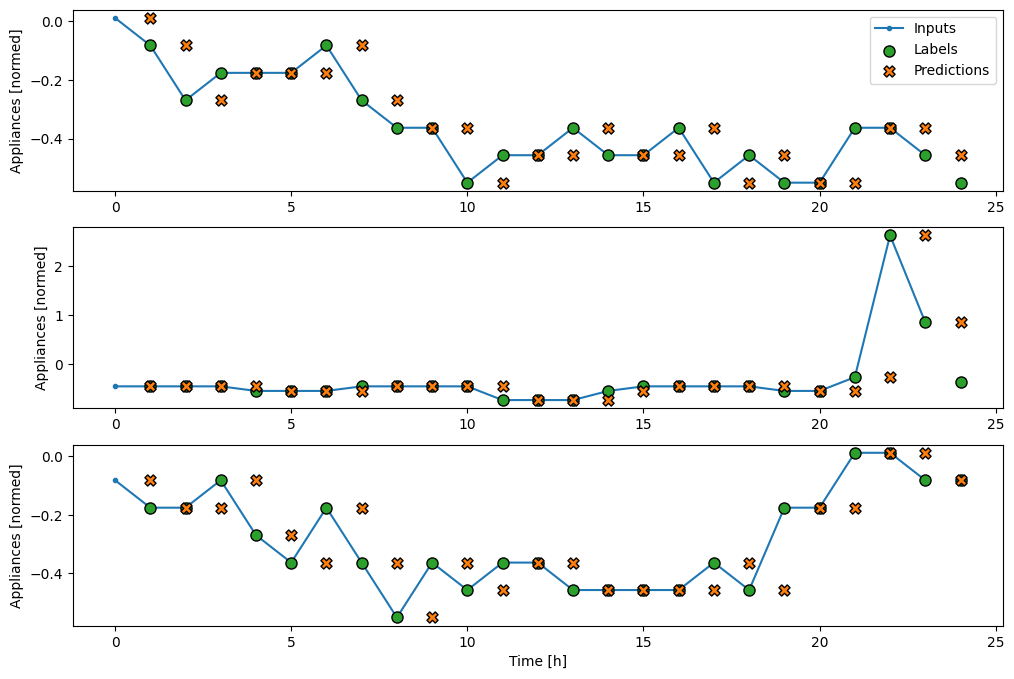

In [ ]:
wide_window.plot(baseline)

#### Variable for storing performance of validation and testing

In [ ]:
val_performance = {} # performance tested on val ds
performance = {}  # performance tested on testing ds

val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

491/491 [==============================] - 1s 2ms/step - loss: 0.0301 - mean_absolute_error: 0.0467


## Training Procedure

In [ ]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### RNN

In [ ]:
rnn = Sequential()
rnn.add(SimpleRNN(64 , return_sequences=True))
rnn.add(Dense(num_features))

### LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dense(num_features))

### Bi-LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(Dense(num_features))

### GRU

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(64,return_sequences=True))
gru_model.add(Dense(num_features))

### Bi-GRU

In [ ]:
bi_gru = Sequential()
bi_gru.add(Bidirectional(GRU(10, return_sequences=True)))
bi_gru.add(Dense(num_features))

--------------------------------------------------------------------------------

## Evaluation Procedure

### Evaluating RNN

In [ ]:
history = compile_and_fit(rnn , wide_window)

IPython.display.clear_output()
val_performance['RNN'] = rnn.evaluate(wide_window.val)
performance['RNN'] = rnn.evaluate(wide_window.test, verbose=0)

491/491 [==============================] - 2s 4ms/step - loss: 0.0725 - mean_absolute_percentage_error: 32.0612


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', rnn(wide_window.example[0]).shape)

Input shape: (8, 24, 26)
Output shape: (8, 24, 26)


### Evaluating lstm model

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

491/491 [==============================] - 3s 5ms/step - loss: 0.0685 - mean_absolute_percentage_error: 35.4420


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (8, 24, 26)
Output shape: (8, 24, 26)


### Evaluating Bi-LSTM model

In [ ]:
history = compile_and_fit(model, wide_window)

IPython.display.clear_output()
val_performance['Bi-LSTM'] = model.evaluate(wide_window.val)
performance['Bi-LSTM'] = model.evaluate(wide_window.test, verbose=0)

491/491 [==============================] - 3s 6ms/step - loss: 0.0770 - mean_absolute_percentage_error: 58.9582


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model(wide_window.example[0]).shape)

Input shape: (8, 24, 26)
Output shape: (8, 24, 26)


### Evaluating GRU model

In [ ]:
history = compile_and_fit(gru_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = gru_model.evaluate(wide_window.val)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)

491/491 [==============================] - 2s 5ms/step - loss: 0.0569 - mean_absolute_percentage_error: 32.5609


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', gru_model(wide_window.example[0]).shape)

Input shape: (8, 24, 26)
Output shape: (8, 24, 26)


### Evaluating Bi-GRU

In [ ]:
history = compile_and_fit(bi_gru, wide_window)

IPython.display.clear_output()
val_performance['Bi-GRU'] = bi_gru.evaluate(wide_window.val)
performance['Bi-GRU'] = bi_gru.evaluate(wide_window.test, verbose=0)

491/491 [==============================] - 3s 6ms/step - loss: 0.0516 - mean_absolute_percentage_error: 48.2562


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', bi_gru(wide_window.example[0]).shape)

Input shape: (8, 24, 26)
Output shape: (8, 24, 26)


## Performance

In [ ]:
# wide_window.plot(model)

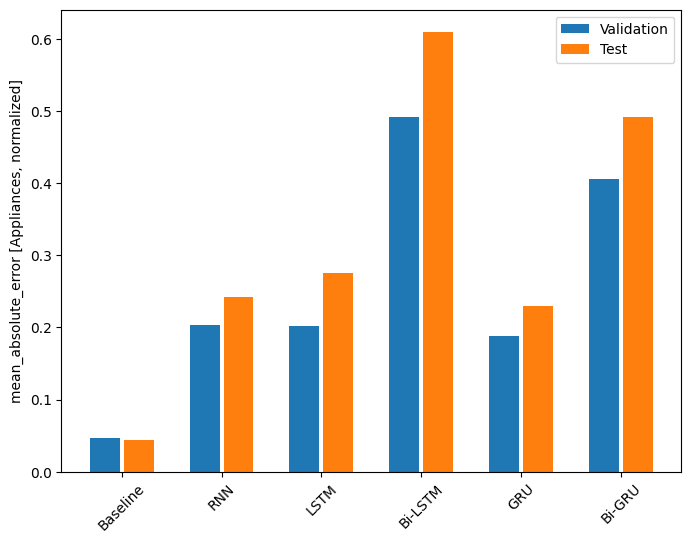

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Appliances, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0443
RNN         : 0.2420
LSTM        : 0.2758
Bi-LSTM     : 0.6098
GRU         : 0.2293
Bi-GRU      : 0.4915


### Graphical Representation